# Inpainting Project

importing libraries we are going to need :

In [1]:
import imageio as iio
import numpy as np
import matplotlib.pyplot as plt

### Image Reading

In [2]:
#im=iio.imread('cloth.jpg',as_gray=True)

### Image Display

In [3]:
def view(data, size=(5, 5), dpi=100):
    """
    Image Dispaly
    """
    fig = plt.figure()
    fig.set_size_inches(size)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    plt.set_cmap('gray')
    ax.imshow(data)

### Rectangular mask creating function

In [4]:
def mask(im, x1, x2 , y1 , y2):
    """
    Takes into argument image , and four coodinates and
    produces mask that has image size 
    """
    shape = im.shape
    mask = np.ones((shape[0],shape[1]), dtype=int)
    for i in range(x1,x2):
        for j in range(y1,y2):
            mask[i,j]=0
    return mask

In [5]:
def delete_zone(im,mask):
    """
    Takes as argument image and mask and produces image with
    nullified zone 
    """
    return im*mask

## Patch manipulations :

In [6]:
def get_patch(image,p,patch_size=16):
    """
    Returns a patch centered on p
    """
    r = patch_size//2
    clip = image[p[0]-r:p[0]+r+1,p[1]-r:p[1]+r+1]
    return clip    

def similarity(patch1 , patch2):
    return np.sum((patch1-patch2)**2)

# Let's calculate the priority term

## Confidence term

In [7]:
def c_matrix(mask):
    n,m= mask.shape
    c=np.zeros(mask.shape)
    for k in range(n):
        for l in range(m):
            patch = get_patch(mask,(k,l))
            c[k,l]=np.sum(patch)/(patch.shape[0]*patch.shape[1])
    return c

#view(c_matrix(mask(im, 10, 100 , 20, 200)))

In [8]:
#mask=mask(im, 10, 100 , 20, 200)
#view(delete_zone(im,mask))

In [9]:
#Bords du mask rectangulaire
# We need to find out how to do it in general case 
def init_bord(mask):
    """
    Finds frontieres of a rectangular mask
    """
    
    n,m=mask.shape
    x1, x2 , y1 , y2 , i ,j=0,0,0,0,0,0
    
    while(mask[i][j]==1):
        i+=1
        if (i==n):
            i=0
            j+=1  
            if(j==m):
                return []
    x1=i
    y1=j
    
    frt = []
    
    while(mask[i][j]!=1):
        frt.append((i,j))
        i+=1
        if(i==n):
            i=i-1
            break
    i-=1
    j+=1
    while(mask[i][j]!=1):
        frt.append((i,j))
        j+=1
        if(j==n):
            j=j-1
            break
    j-=1
    i-=1
    while(mask[i][j]!=1):
        frt.append((i,j))
        i-=1
        if(i==-1):
            i=0
            break
    i+=1
    j-=1
    while(mask[i][j]!=1):
        frt.append((i,j))
        j-=1
        if(j==-1):
            j=0
            break
    return frt

def bord_matrix(mask,bord):
    """
    frontiere in a matrix ( for display purpuses only)
    """
    n,m=mask.shape
    bord_matrix=np.zeros((n,m))
    for i in range(n):
        for j in range(m):
            if((i,j) in old):
                bord_matrix[i,j]=1
    return bord_matrix

def update_bord(border , mask , point):
    patch = get_patch(mask,point)
    r=len(patch)//2
    x,y=point
    for i in range(-r,r+1) :
        if mask[x-r-1,y+i] == 0 : border.append((x-r-1,y+i))
        if mask[x+r+1,y+i] == 0 : border.append((x+r+1,y+i))
        if mask[x+i,y-r-1] == 0 : border.append((x+i,y-r-1))
        if mask[x+i,y+r+1] == 0 : border.append((x+i,y+r+1))
                       
    for i in range(-r,r+1) :
        for j in range(-r,r+1):
            try :
                border.remove((x+i,y+j))
            except : 
                pass              
    return border


In [10]:
#old = init_bord(mask)
#view(bord_matrix(mask,old))
#update_bord(old , mask , (20,20))
#view(bord_matrix(mask,old))

In [11]:
def gradient_I(image , mask):
        """
        We compute I(p) for all p in delta(\Omega)
        """
        h, w = image.shape[:2]
        
        # We fill the mask points with nones
        image[mask == 1] = None
        
        # We compute the gradient 
        gradient = np.nan_to_num(np.array(np.gradient(image)))
        norme = np.sqrt(gradient[0]**2 + gradient[1]**2)
        
        fgradx,fgrady = np.array([np.zeros([h, w]),np.zeros([h, w])])
        frontiere = init_bord(mask)
        
        for point in frontiere:
            patch = get_patch(image,point)
            patch_gradx = get_patch(gradient[0], point)
            patch_grady = get_patch(gradient[1], point)
            patch_norm = get_patch(norme, point)
            
            max_patch = np.unravel_index(
                patch_norm.argmax(),
                patch_norm.shape
            )
            fgradx[point[0], point[1]] = patch_gradx[max_patch]
            fgrady[point[0], point[1]] = patch_grady[max_patch]

        return [fgradx,fgrady]
    
    
#I=gradient_I(im , mask)    
#view(I[0])
#view(I[1])

In [12]:
def normal_vect(image,mask,bord) : #n(p)
    h, w = mask.shape[:2]
    coordx , coordy= np.zeros((h, w)),np.zeros((h, w))
    for p in bord:
        i,j=p
        patch = get_patch(mask,(i,j))
        grad = len(patch)*len(patch[0])*np.nan_to_num(np.array(np.gradient(patch)))
        gradX = grad[0]
        gradY = grad[1]
        centerX, centerY = patch.shape[0]//2 ,patch.shape[1]//2
        coordx[i][j] =gradX[centerX][centerY]
        coordy[i][j] =gradY[centerX][centerY]
    return coordx,coordy
#n=normal_vect(im,mask,init_bord(mask))
#view(n[0])
#view(n[1])

In [13]:
def P(image,mask,bordure):
    
    "Computes P for points of the bordure"
    
    h, w = mask.shape[:2]
    P=np.zeros((h,w))
    C=c_matrix(mask)
    I=gradient_I(image , mask)
    N=normal_vect(image,mask,bordure)
    for (i,j) in bordure:
        P[i][j]=np.abs(I[0][i][j]*N[0][i][j]+
            I[1][i][j]*N[1][i][j])/255 * C[i][j]
    return P

def maxP(image,mask,bordure):
    
    "Finds point with max value of P"
    
    p=P(image,mask,bordure)
    maximum=p[bordure[0]]
    argmax=bordure[0]
    for point in bordure:
        i,j=point
        if(p[i][j]>=maximum):
            argmax=point
    return argmax  

In [14]:
#view(P(im,mask,init_bord(mask)))
#print(maxP(im,mask,init_bord(mask)))

# Iteration Of the algorithm

In [15]:
def iterate(image , mask , patch_size = 16):
    frt = init_bord(mask)
    new_image= delete_zone(image,mask)
    view(new_image)

    K=0
    ps=patch_size//2
    
    while (len(frt)>0):
        
        p_point=maxP(new_image,mask,frt)
        p_patch=get_patch(new_image,p_point)
        new_patch = get_patch(new_image, (ps,ps))
        d = similarity(new_patch,p_patch)
        X,Y =0,0
        chosenX,chosenY = p_point
        
        # Looking for a patch that is the closest to the content of uncomplete patch
        for x in range (ps, image.shape[0]-ps):
            for y in range (ps,image.shape[1]-ps) :
                potential = True
                for i in range(x-ps,x+ps+1):
                    for j in range(y-ps,y+ps+1):
                        if(mask[i][j]== 0):
                                potential = False
                if potential :
                    testPatch = get_patch(new_image,(x,y))
                    dtest = similarity(p_patch,testPatch)
                    if dtest < d :
                        d = dtest
                        new_patch = testPatch
                        X,Y = x,y
        
        update_bord(frt,mask,(chosenX,chosenY))
        # Filling
        for i in range(-ps,ps+1) :
            for j in range(-ps,ps+1):
                mask[chosenX+i,chosenY+j]= 1
                new_image[chosenX+i,chosenY+j]= new_patch[ps+i,ps+j]
        view(new_image)
        iio.imwrite("output/"+str(K)+".jpg", np.uint8(new_image))
        print(len(frt))
        K+=1

/tmp/ipykernel_8005/1527826173.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im=iio.imread('cloth.jpg',as_gray=True)
/tmp/ipykernel_8005/2695204252.py:7: RuntimeWarning: invalid value encountered in long_scalars
  c[k,l]=np.sum(patch)/(patch.shape[0]*patch.shape[1])


38
21


KeyboardInterrupt: 

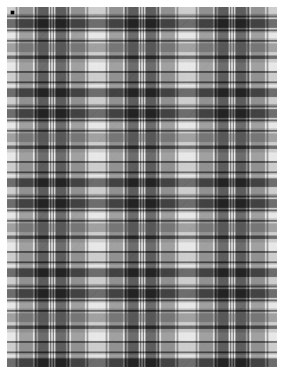

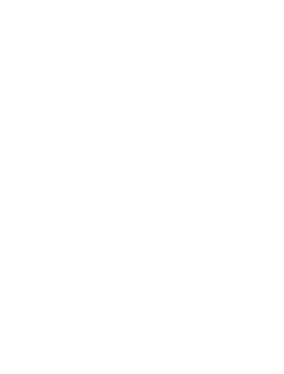

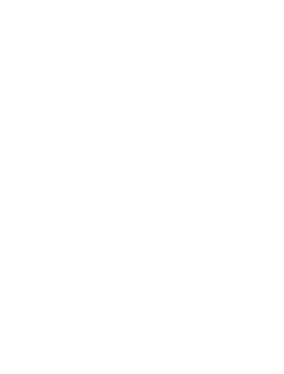

In [16]:
im=iio.imread('cloth.jpg',as_gray=True)
mask=mask(im, 10, 20 , 10, 20)

iterate(im , mask)